# ***California Housing Price Prediction - Polynomial Regression***
***Nov 2025***

# 🔶Import Libraries

This notebook builds on the preprocessing steps created earlier and evaluates Polynomial Regression as a non-linear alternative to the SGDRegressor. The goal is to capture non-linear relationships and overcome the underprediction issues observed in the SGDRegressor model.

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import skew, boxcox, yeojohnson

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import missingno as msno

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer # For Missing Value Handeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDRegressor, ElasticNetCV , RidgeCV, LassoCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

import joblib

# 🔶Data Overview

In [45]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## ⮞Casting Object Data as Categorical Data

In [46]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')
df.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,category


# 🔶Train-Test Split

In [47]:
# Create income categories
df["income_cat"] = pd.cut(
    df["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [48]:
# Test Size = 20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df["income_cat"]):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

# Drop income-cat, it was only used for splitting
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f'Shape of Train Set: {train_set.shape}')
print(f'Shape of Test Set: {test_set.shape}')

Shape of Train Set: (16512, 10)
Shape of Test Set: (4128, 10)


# 🔶Missing Values

In [49]:
train_set.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,168
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


## ⮞Handeling Missing Values

In [50]:
print(f' mean={train_set['total_bedrooms'].mean()}\n median={train_set['total_bedrooms'].median()}\n mode={train_set['total_bedrooms'].mode()}')

 mean=538.9490944689182
 median=434.0
 mode=0    345.0
Name: total_bedrooms, dtype: float64


In [51]:
# Replacing the missing values in the train_set with the median of the column:
train_median = train_set['total_bedrooms'].median()

train_set.fillna({'total_bedrooms' : train_median}, inplace=True)
train_set['total_bedrooms'].isna().sum()

np.int64(0)

In [52]:
# Alternative method for missing value handeling using sklearn imputer
"""
imputer = SimpleImputer(strategy='median')

cols = train_set.select_dtypes('float64').columns   # Imputer won't work with non-numeric columns
imputer.fit_transform(train_set[cols])
imputer.statistics_, m

imputer.transform(test_set)
"""

"\nimputer = SimpleImputer(strategy='median')\n\ncols = train_set.select_dtypes('float64').columns   # Imputer won't work with non-numeric columns\nimputer.fit_transform(train_set[cols])\nimputer.statistics_, m\n\nimputer.transform(test_set)\n"

# 🔶Encoding Categorical Features

In [53]:
train_set.ocean_proximity.unique()

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Categories (5, object): ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

## ⮞One-Hot Encoding

In [54]:
train_set = pd.get_dummies(train_set, columns=['ocean_proximity'], dtype=np.float64)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,0.0,0.0,0.0,1.0,0.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,1.0,0.0,0.0,0.0,0.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,0.0,1.0,0.0,0.0,0.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,0.0,1.0,0.0,0.0,0.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,0.0,0.0,0.0,0.0,1.0


## ⮞Creating More Codeable Column Name in the Train Set

In [55]:
# Lower case, No space
train_set.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1h_ocean',
                          'ocean_proximity_INLAND' :'ocean_proximity_inland',
                          'ocean_proximity_ISLAND' : 'ocean_proximity_island',
                          'ocean_proximity_NEAR BAY' : 'ocean_proximity_near_bay',
                          'ocean_proximity_NEAR OCEAN' : 'ocean_proximity_near_ocean'},
                 inplace=True)

train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,0.0,0.0,0.0,1.0,0.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,1.0,0.0,0.0,0.0,0.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,0.0,1.0,0.0,0.0,0.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,0.0,1.0,0.0,0.0,0.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,0.0,0.0,0.0,0.0,1.0


# 🔶Outliers

## ⮞Univariate Analysis

### ▸Numerical Features

In [56]:
# Make a copy of the dataset to apply feature transformation
preprocessed_train_set = train_set.copy()

In [57]:
# Apply feature transformation
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
lambda_list = []
for col in cols_to_transform:
  preprocessed_train_set[col], lm = yeojohnson(train_set[col])
  lambda_list.append(lm)      # This will be used for test_set feature transformation

In [58]:
desc = preprocessed_train_set[cols_to_transform].describe()
Q1 = desc.loc['25%']
Q3 = desc.loc['75%']
IQR = Q3 - Q1
#lower_cap = Q1 - 1.5 * IQR   # we increase the range between two caps to 3.3IQR so that a smaller number of samples will be considered as outliers.
#upper_cap = Q3 + 1.5 * IQR
lower_cap = Q1 - 3.3 * IQR
upper_cap = Q3 + 3.3 * IQR

flags = (preprocessed_train_set[cols_to_transform] < lower_cap) | (preprocessed_train_set[cols_to_transform] > upper_cap)
flags.sum()

,0
total_rooms,25
total_bedrooms,23
population,12
households,19
median_income,0
median_house_value,0


In [59]:
# Summing up the outliers in rows to detect the actual number of outlier sampels withot overlappng
print(f' Total number of outlier samples: {flags.sum(1).astype(np.bool_).sum()}')

 Total number of outlier samples: 36


In [60]:
# dropping the outliers(outside the range of caps)

print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{flags.sum(1).astype(np.bool_).sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[~flags.sum(1).astype(np.bool_)]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:16512
Number of outliers to drop:36
Number of samples after dropping the outliers:16476


Number of outliers in median_house_value: 807


Text(0.5, 1.0, 'Median House Value Without the Outlier Bar at $500000(32.5 after transformation)')

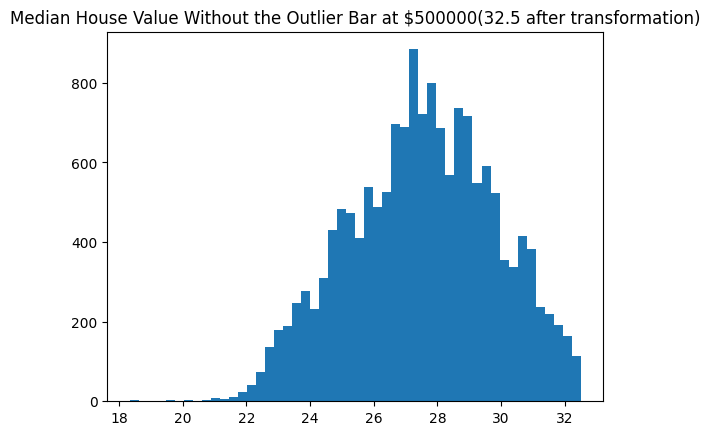

In [61]:
# Handling the outliers in median_house_value(~800 samples at $500,000)
flags = preprocessed_train_set.median_house_value < 32.5
print(f'Number of outliers in median_house_value: {(~flags).sum()}')
plt.hist(preprocessed_train_set.median_house_value[flags], 50);
plt.title('Median House Value Without the Outlier Bar at $500000(32.5 after transformation)')

In [62]:
# dropping the outliers(capped at $500,000)

print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{(~flags).sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[flags]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:16476
Number of outliers to drop:807
Number of samples after dropping the outliers:15669


In [63]:
# Apply exponent feature transform on median house value to fix the left skew

preprocessed_train_set['median_house_value'] = (preprocessed_train_set.median_house_value)**1.8

In [64]:
# dropping the outliers(Lower than 240)
flags = preprocessed_train_set['median_house_value'] < 240
print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{flags.sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[~flags]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:15669
Number of outliers to drop:18
Number of samples after dropping the outliers:15651


### ▸Categorical Features

In [65]:
preprocessed_train_set.iloc[:, 9:].sum()

,0
ocean_proximity_1h_ocean,6814.0
ocean_proximity_inland,5252.0
ocean_proximity_island,2.0
ocean_proximity_near_bay,1679.0
ocean_proximity_near_ocean,1904.0


In [66]:
# Dropping the ocean_proximity_island due to the mentioned reasons
preprocessed_train_set.drop(columns='ocean_proximity_island', inplace=True)
preprocessed_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_near_bay,ocean_proximity_near_ocean
13096,-122.42,37.80,52.0,21.885560,16.237258,19.989298,17.559147,1.015860,515.734944,0.0,0.0,1.0,0.0
14973,-118.38,34.14,40.0,19.059757,11.705350,15.516368,12.730667,1.630253,523.506281,1.0,0.0,0.0,0.0
3785,-121.98,38.36,33.0,16.215315,10.087305,14.737976,10.622497,1.097377,336.524088,0.0,1.0,0.0,0.0
14689,-117.11,33.75,17.0,23.219759,15.067641,20.911629,16.158466,1.056877,331.008794,0.0,1.0,0.0,0.0
20507,-118.15,33.77,36.0,23.490025,16.608470,21.125243,18.212246,1.309943,482.986761,0.0,0.0,0.0,1.0


## ⮞Bivariate Analysis

In [67]:
# Make a copy of the dataset to later examine the model's performance with and without the outliers
clean_train_set = preprocessed_train_set.copy()

Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Longitude: 24')

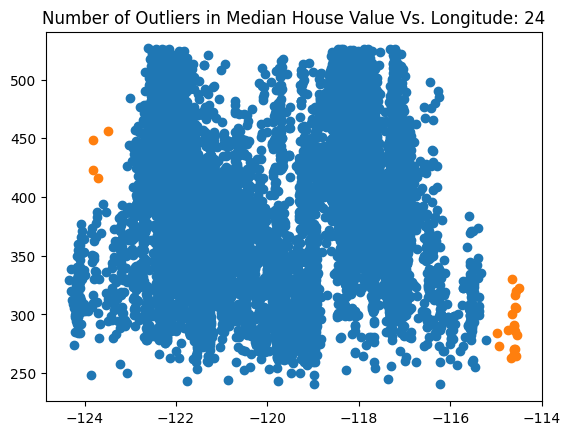

In [68]:
# Outliers in longitude
flag1 = (clean_train_set.longitude < -123.2) & (clean_train_set.median_house_value > 410)
flag2 = clean_train_set.longitude > -115
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.longitude[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.longitude[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Longitude: {count}')

In [69]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15651
Number of outliers to drop:24
Number of samples after dropping the outliers:15627


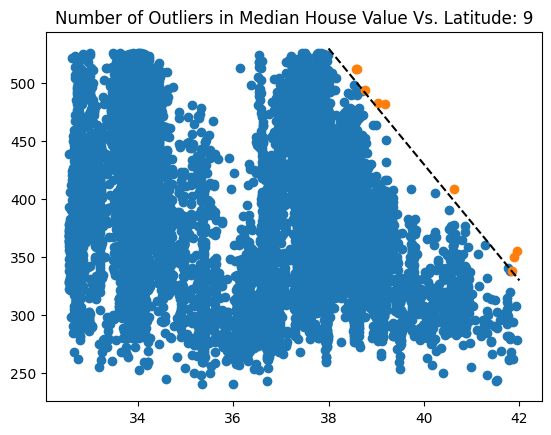

In [70]:
# Outliers in latitude
m = -50
b = 2430
flag1 = clean_train_set.median_house_value > (m * clean_train_set.latitude + b)
flags =  flag1
count = flags.sum()

plt.scatter(clean_train_set.latitude[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.latitude[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Latitude: {count}')

# Plot the line
lat_range = np.linspace(38,42, 20)
plt.plot(lat_range, m * lat_range + b, 'k--')

In [71]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15627
Number of outliers to drop:9
Number of samples after dropping the outliers:15618


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Housing_median_age: 869')

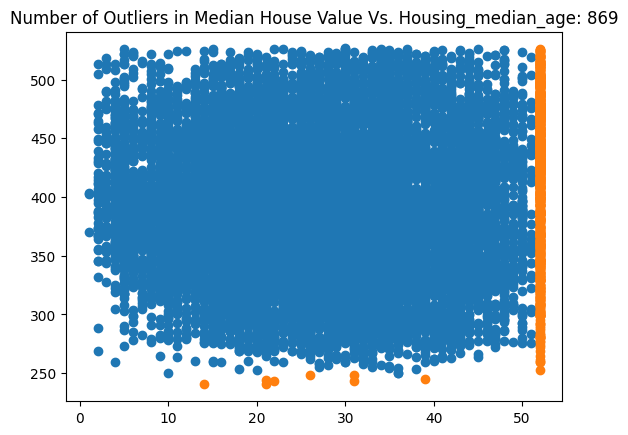

In [72]:
# Outliers in housing_median_age
flag1 = clean_train_set.median_house_value < 250
flag2 = clean_train_set.housing_median_age > 51
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.housing_median_age[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.housing_median_age[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Housing_median_age: {count}')

In [73]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15618
Number of outliers to drop:869
Number of samples after dropping the outliers:14749


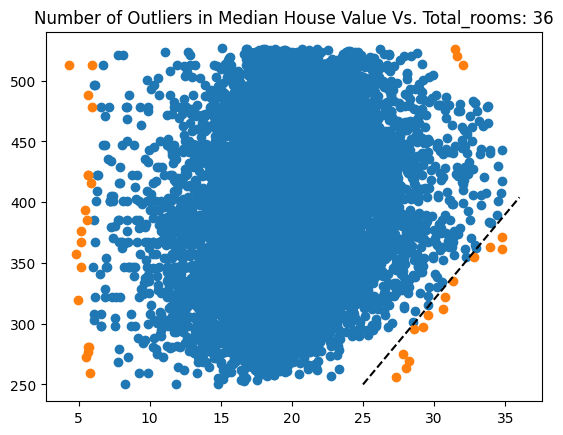

In [74]:
# Outliers in total_rooms
m = 14
b = -100
flag1 = clean_train_set.median_house_value < (m * clean_train_set.total_rooms + b)
flag2 = (clean_train_set.total_rooms > 31) & (clean_train_set.median_house_value > 510)
flag3 = clean_train_set.total_rooms < 6
flags =  flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.total_rooms[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.total_rooms[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Total_rooms: {count}')

# Plot the line
l_range = np.linspace(25,36, 20)
plt.plot(l_range, m * l_range + b, 'k--')

In [75]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14749
Number of outliers to drop:36
Number of samples after dropping the outliers:14713


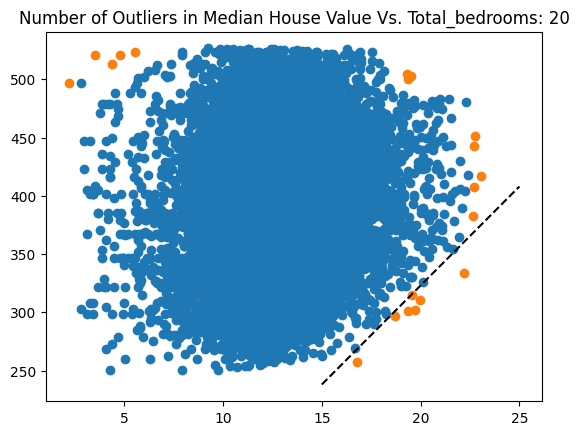

In [76]:
# Outliers in total_bedrooms
m = 17
b = -17
flag1 = clean_train_set.median_house_value < (m * clean_train_set.total_bedrooms + b)
flag2 = (clean_train_set.total_bedrooms > 18.5) & (clean_train_set.median_house_value > 500)
flag3 = (clean_train_set.total_bedrooms < 6) & (clean_train_set.median_house_value > 501)
flag4 = (clean_train_set.total_bedrooms > 22.5) | (clean_train_set.total_bedrooms < 2.5)
flags =  flag1 | flag2 | flag3 | flag4
count = flags.sum()

plt.scatter(clean_train_set.total_bedrooms[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.total_bedrooms[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Total_bedrooms: {count}')

# Plot the line
l_range = np.linspace(15,25, 20)
plt.plot(l_range, m * l_range + b, 'k--')

In [77]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14713
Number of outliers to drop:20
Number of samples after dropping the outliers:14693


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Population: 5')

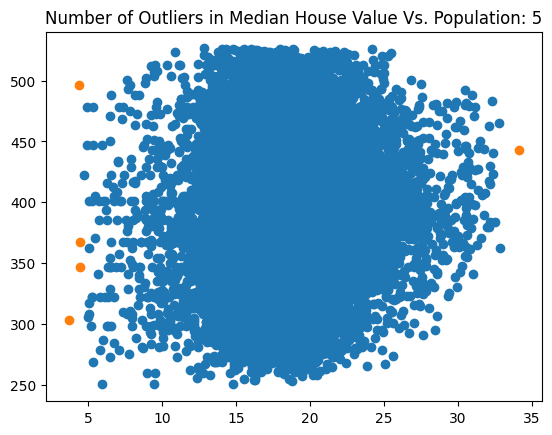

In [78]:
# Outliers in population
flag1 = clean_train_set.median_house_value < 250
flag2 = (clean_train_set.population < 4.5) | (clean_train_set.population > 33)
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.population[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.population[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Population: {count}')

In [79]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14693
Number of outliers to drop:5
Number of samples after dropping the outliers:14688


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Households: 24')

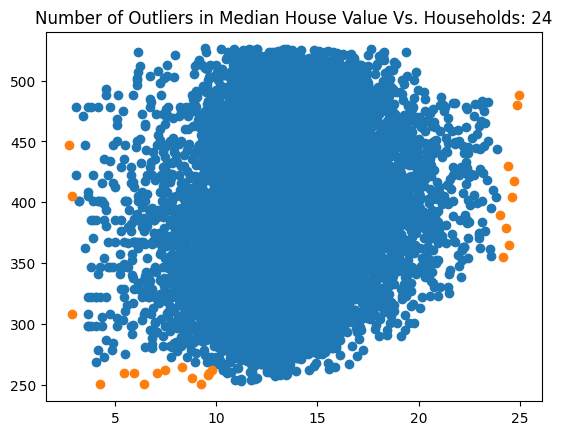

In [80]:
# Outliers in households
flag1 = (clean_train_set.households > 20) & (clean_train_set.median_house_value > 500)
flag2 = (clean_train_set.households < 3) | (clean_train_set.households > 24)
flag3 = (clean_train_set.households < 10) & (clean_train_set.median_house_value < 265)
flags = flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.households[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.households[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Households: {count}')

In [81]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14688
Number of outliers to drop:24
Number of samples after dropping the outliers:14664


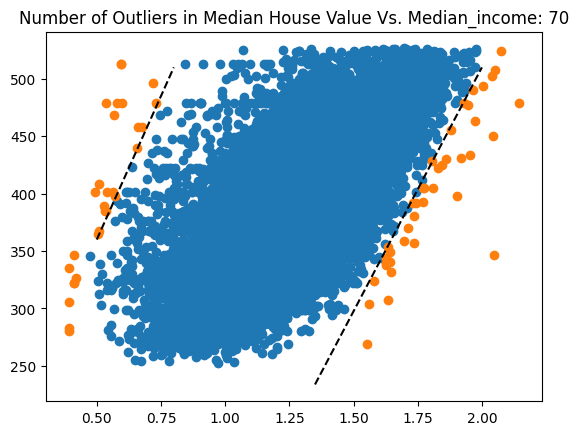

In [82]:
# Outliers in median_income
m1 = 425
b1 = -340
m2 = 500
b2 = 110
flag1 = clean_train_set.median_house_value < (m1 * clean_train_set.median_income + b1)
flag2 = clean_train_set.median_house_value > (m2 * clean_train_set.median_income + b2)
flag3 = (clean_train_set.median_income < 0.45)
flags = flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.median_income[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.median_income[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Median_income: {count}')
# Plot the lines
l1_range = np.linspace(1.35,2, 20)
plt.plot(l1_range, m1 * l1_range + b1, 'k--')
l2_range = np.linspace(0.5,0.8, 20)
plt.plot(l2_range, m2 * l2_range + b2, 'k--')

In [83]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14664
Number of outliers to drop:70
Number of samples after dropping the outliers:14594


Now that we have identified the outliers through bivariate analysis, we can evaluate their impact on the model. The approach is to first use the dataset that retains all outliers(preprocessed_train_set), build and train the model, and record its performance. Then, we can use the dataset in which the detected outliers are removed(clean_train_set), retrain the model, and compare the results.

By examining the performance difference between the two scenarios, we can make an informed decision about whether keeping or removing the outliers leads to a more robust and reliable model.

# 🔶Data/Feature Reduction

In [84]:
corr = preprocessed_train_set.corr()
corr[['median_house_value']].abs().sort_values(by='median_house_value')

,median_house_value
longitude,0.028536
housing_median_age,0.046773
population,0.051845
total_bedrooms,0.109908
ocean_proximity_near_ocean,0.131981
households,0.138668
ocean_proximity_near_bay,0.164057
latitude,0.182600
total_rooms,0.197033
ocean_proximity_1h_ocean,0.337791


# 🔶X & Y Split

In [85]:
# Separate the dataset into features (X) and the target variable (y)- Outliers retained
x_train = preprocessed_train_set.drop(columns=['median_house_value'])
y_train = preprocessed_train_set['median_house_value']

x_train.shape, y_train.shape

((15651, 12), (15651,))

In [86]:
# Separate the dataset into features (X) and the target variable (y)- Outliers removed
x_train_c = clean_train_set.drop(columns=['median_house_value'])
y_train_c = clean_train_set['median_house_value']

x_train_c.shape, y_train_c.shape

((14594, 12), (14594,))

# 🔶Model Selection

As our data showed non-linear behavior, here we examine the polynomial feature transformer along with the Elasticnet model.

## ⮞Polynomial Regression

The scaling process should be implemented within the pipeline to prevent data leakage during cross-validation, ensuring that scaling parameters are computed only from the training fold in each CV iteration.

### ▸Model 1

In [87]:
# Model will be trained on normalized data(in range[0,1])
poly_model_1 = make_pipeline(
               PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
               MinMaxScaler(),
               ElasticNetCV(l1_ratio=np.linspace(0.01,1,5),   # range of l1_ratio to search
                            alphas=np.logspace(-2, 0, 5),  # range of alpha (regularization strength)
                            cv=5,                           # number of folds for cross-validation
                            max_iter=20000,
                            random_state=42,
                            n_jobs=-1,
                            tol=1e-3
                            )
                            )

In [88]:

poly_model_1.fit(x_train_c, y_train_c.to_numpy())

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('minmaxscaler', MinMaxScaler()),
                ('elasticnetcv',
                 ElasticNetCV(alphas=array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]),
                              cv=5,
                              l1_ratio=array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                              max_iter=20000, n_jobs=-1, random_state=42,
                              tol=0.001))])

In [119]:
best_alpha_1 = poly_model_1.named_steps['elasticnetcv'].alpha_
best_l1_ratio_1 = poly_model_1.named_steps['elasticnetcv'].l1_ratio_
r2_train_1 = poly_model_1.score(x_train_c, y_train_c)

print(f"Best alpha: {best_alpha_1}")
print(f"Best l1_ratio: {best_l1_ratio_1}")
print(f"R² on training set: {r2_train_1}")

Best alpha: 0.01
Best l1_ratio: 1.0
R² on training set: 0.7142469533648009


|           Model                 | Outliers |    R²         |
| ------------------------------- | -------- | ------------- |
| **Poly-degree-2 + ElasticNet**  | Retained | **0.7012**    |
| **Poly-degree-2 + ElasticNet**  | Removed  | **0.7142**    |


### ▸Model 2

In [90]:
# Model will be trained on standardized data(mean=0, std=1)
poly_model_2 = make_pipeline(
               PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
               StandardScaler(),
               ElasticNetCV(l1_ratio=np.linspace(0.01,1,5),   # range of l1_ratio to search
                            alphas=np.logspace(-2, 1, 5),  # range of alpha (regularization strength)
                            cv=5,                           # number of folds for cross-validation
                            max_iter=20000,
                            random_state=42,
                            n_jobs=-1,
                            tol=1e-3
                            )
                            )

In [91]:
poly_model_2.fit(x_train_c, y_train_c.to_numpy())

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60924.94397328235, tolerance: 37934.46033035526
  model = cd_fast.enet_coordinate_descent_gram(


Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('elasticnetcv',
                 ElasticNetCV(alphas=array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                              cv=5,
                              l1_ratio=array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                              max_iter=20000, n_jobs=-1, random_state=42,
                              tol=0.001))])

In [120]:
best_alpha_2 = poly_model_2.named_steps['elasticnetcv'].alpha_
best_l1_ratio_2 = poly_model_2.named_steps['elasticnetcv'].l1_ratio_
r2_train_2 = poly_model_2.score(x_train_c, y_train_c)

print(f"Best alpha: {best_alpha_2}")
print(f"Best l1_ratio: {best_l1_ratio_2}")
print(f"R² on training set: {r2_train_2}")

Best alpha: 0.01
Best l1_ratio: 1.0
R² on training set: 0.7283927140307476


|           Model                 | Outliers |    R²         |
| ------------------------------- | -------- | ------------- |
| **Poly-degree-2 + ElasticNet**  | Retained | **0.7145**    |
| **Poly-degree-2 + ElasticNet**  | Removed  | **0.7283**    |


### ▸Model 3

In [133]:
# Model will be trained on standardized data(mean=0, std=1)
poly_model_3 = make_pipeline(
               PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
               StandardScaler(),
               LassoCV(alphas=np.logspace(-2, 0, 10),  # range of alpha (regularization strength)
                            cv=5,                      # number of folds for cross-validation
                            max_iter=20000,
                            random_state=42,
                            n_jobs=-1,
                            tol=1e-3
                            )
                            )

In [134]:
poly_model_3.fit(x_train_c, y_train_c.to_numpy())

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('lassocv',
                 LassoCV(alphas=array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         cv=5, max_iter=20000, n_jobs=-1, random_state=42,
                         tol=0.001))])

In [132]:
best_alpha_3 = poly_model_3.named_steps['lassocv'].alpha_
r2_train_3 = poly_model_3.score(x_train_c, y_train_c)

print(f"Best alpha: {best_alpha_2}")
print(f"R² on training set: {r2_train_2}")

Best alpha: 0.01
R² on training set: 0.7283927140307476


|           Model            | Outliers |    R²         |
| -------------------------- | -------- | ------------- |
| **Poly-degree-2 + Lasso**  | Retained | **0.7145**    |
| **Poly-degree-2 + Lasso**  | Removed  | **0.7283**    |
| **Poly-degree-3 + Lasso**  | Removed  | **0.728314**  |
| **Poly-degree-5 + Lasso**  | Removed  | **0.728392**  |


**Interpretation of Model Results**

After experimenting with a wide range of hyperparameters, evaluating the model based on different scaling techniques(normalization Vs standardization), experimenting with the models trained on data with and without outliers, and evaluating the models with different degrees of polynomial, the overall model performance remained stable. However, the model kept choosing the lowest value of regularization strength, which led to a convergence warning. To overcome the convergence warning('the Objective did not converge...'), I narrowed down the range of alpha to (0.01, 1). Within this range, the lowest value was always chosen by the model.

Key observations are as follows:
* Best alpha = 0.01: This is a small regularization strength, meaning the model relies mostly on fitting the data rather than shrinking coefficients.
This often happens when the dataset is not very noisy and The polynomial features add meaningful signal that the model wants to keep.
* Best l1_ratio = 1.0: This indicates the model prefers pure Lasso regression (L1 penalty only).Lasso tends to set small or irrelevant coefficients exactly to zero, which helps with feature selection. This can be particularly helpful with polynomial features, where many interactions might be less important. Also to further investigate the model, a pure Lasso model is also examined, which represents the exact same values as the ElasticNet model.
* R² ≈ 0.728 on training set: The model explains about 72.8% of the variance in the training data. This is higher than the SGDRegressor result (≈0.67), showing that the polynomial features and L1 regularization help capture the non-linear relationships in the data.
* Polynomial degree=2: The selected degree meaningfully improves the performance compared to SGDRegressor, but higher polynomial degrees(3 or 5) offer no additional gain and only increase the computational time and cost.

## ⮞Best Model

In [136]:
# Extract LassoCV step
lasso_model = poly_model_3[-1]

# Coefficients
coefficients = lasso_model.coef_

# Get polynomial feature names
poly = poly_model_3[0]
feature_names = poly.get_feature_names_out(x_train.columns)

# Combine into a table
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

coef_df.sort_values(by="coefficient", key=abs, ascending=False).head(10)


,feature,coefficient
45,total_rooms median_income,182.953105
52,total_bedrooms median_income,-87.550383
3,total_rooms,-77.765473
36,housing_median_age households,60.808693
23,latitude housing_median_age,-54.050791
47,total_rooms ocean_proximity_inland,46.010313
51,total_bedrooms households,45.777872
43,total_rooms population,-45.149984
35,housing_median_age population,-44.851989
20,longitude ocean_proximity_inland,43.806804


1. total_rooms × median_income → strong positive: This is the largest coefficient.
It means that neighborhoods with many rooms and high incomes show the strongest increase in housing prices, or expensive large houses appear mainly in wealthy regions, amplifying price.

2. total_bedrooms × median_income → Surprisingly strong negative: Meaning when median income increases, houses with many bedrooms do not increase in value as much as expected.That might be due to overcrowding or poor room quality in high-income areas.

3. total_rooms → negative main effect: Alone, more rooms leads to lower price, which seems contradictory. Raw "room count" does not guarantee high prices without context (income, location).

## ⮞Save the Best Model

In [137]:
# Save the entire pipeline (scaler + polynomial features + model)
joblib.dump(poly_model_3, "polynomial_lasso_model.pkl")
print("Model saved successfully!")

Model saved successfully!


# 🔶Test the Model

In [98]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY


## ⮞Test Set Preprocessing

### ▸Missing Values

In [99]:
test_set.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,39
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [100]:
# Replacing the missing values in the test_set using the median of train_set
test_set.fillna({'total_bedrooms' : train_median}, inplace=True)

### ▸Encoding Categorical Features

In [101]:
# apply the same encoding strategy as used in the training set
test_set = pd.get_dummies(test_set, columns=['ocean_proximity'], dtype=np.float64)


In [102]:
# Lower case, No space
test_set.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1h_ocean',
                          'ocean_proximity_INLAND' :'ocean_proximity_inland',
                          'ocean_proximity_ISLAND' : 'ocean_proximity_island',
                          'ocean_proximity_NEAR BAY' : 'ocean_proximity_near_bay',
                          'ocean_proximity_NEAR OCEAN' : 'ocean_proximity_near_ocean'},
                 inplace=True)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,1.0,0.0,0.0,0.0,0.0
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,1.0,0.0,0.0,0.0,0.0
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,0.0,0.0,0.0,0.0,1.0
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,0.0,0.0,0.0,0.0,1.0
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,0.0,0.0,0.0,1.0,0.0


### ▸Outlier Detection & Feature Transformation

When working with the test set, the goal is to evaluate the model's performance on data that reflects real-world conditions.
Unlike the training set, we cannot remove samples based on outlier detection, because doing so would artificially improve performance and introduce bias.

Instead, we:
* Detect outliers in the test set using the same rules and thresholds defined during preprocessing (univariate and bivariate analysis).
* Do not drop these outlier samples.
* Report the presence and number of outliers as part of the model evaluation.

This ensures that the model is tested on the full range of data it may see in practice and that the reported performance remains fair and unbiased.

#### . Univariate Analysis

In [103]:
# Apply yeo-johnson feature transformation with the same lambda used for train_set to minimize the number of outliers
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
for i, col in enumerate(cols_to_transform):
  test_set[col] = yeojohnson(test_set[col], lambda_list[i])
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
3905,-121.95,37.11,21.0,20.070367,11.734775,17.048969,12.548645,1.770587,31.435692,1.0,0.0,0.0,0.0,0.0
16821,-118.01,33.89,36.0,18.003663,10.727406,16.417373,11.679686,1.469717,28.302954,1.0,0.0,0.0,0.0,0.0
2900,-118.18,33.74,30.0,25.384720,18.345262,21.800360,19.567830,1.397106,30.245815,0.0,0.0,0.0,0.0,1.0
7193,-122.48,37.74,52.0,19.560390,12.337749,17.874370,12.874036,1.401984,30.310666,0.0,0.0,0.0,0.0,1.0
13928,-122.39,37.78,5.0,17.413424,13.065358,15.917496,13.108147,1.322106,27.952146,0.0,0.0,0.0,1.0,0.0


In [104]:
# Outliers in numeric columns detected by upper/lower caps of train set
f1 = (test_set[cols_to_transform] < lower_cap) | (test_set[cols_to_transform] > upper_cap)
f1_row = f1.any(axis=1)
f1_count = f1_row.sum()
print(f' Count of outliers:{f1_count}')
print(f' Shape:{f1_row.shape}')

 Count of outliers:12
 Shape:(4128,)


In [105]:
# Outliers in median_house_value( samples capped at $500,000)
f2 = test_set.median_house_value >= 32.5
f2_count = f2.sum()
print(f' Count of outliers:{f2_count}')
print(f' Shape:{f2.shape}')

 Count of outliers:205
 Shape:(4128,)


In [106]:
# Apply the same exponent transformation as used on the training set, median_house_value
test_set['median_house_value'] = (test_set.median_house_value)**1.8
# Outliers in median_house_value(Lower than 240)
f3 = test_set['median_house_value'] < 240
f3_count = f3.sum()
print(f' Count of outliers:{f3_count}')
print(f' Shape:{f3.shape}')

 Count of outliers:2
 Shape:(4128,)


In [107]:
# Total outliers detected through univariate analysis
uni_outliers = f1_row | f2 | f3
uni_outliers_count = uni_outliers.sum()
test_uni_outliers = test_set.loc[uni_outliers]
print(f' Shape:{test_uni_outliers.shape}')
print(f' Total count of univariate outliers:{uni_outliers_count}')

 Shape:(218, 14)
 Total count of univariate outliers:218


#### . Bivariate Analysis

In [108]:
# Outliers in longitude
flag1 = (test_set.longitude < -123.2) & (test_set.median_house_value > 410)
flag2 = test_set.longitude > -115
flags1 = flag1 | flag2
flags_count = flag1.sum()
print(f' Shape:{flags1.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in latitude
m = -50
b = 2430
flag1 = test_set.median_house_value > (m * test_set.latitude + b)
flags2 =  flag1
flags_count = flags2.sum()
print(f' Shape:{flags2.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in housing_median_age
flag1 = test_set.median_house_value < 250
flag2 = test_set.housing_median_age > 51
flags3 = flag1 | flag2
flags_count = flags3.sum()
print(f' Shape:{flags3.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in total_rooms
m = 14
b = -100
flag1 = test_set.median_house_value < (m * test_set.total_rooms + b)
flag2 = (test_set.total_rooms > 31) & (test_set.median_house_value > 510)
flag3 = test_set.total_rooms < 6
flags4 =  flag1 | flag2 | flag3
flags_count = flags4.sum()
print(f' Shape:{flags4.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in total_bedrooms
m = 17
b = -17
flag1 = test_set.median_house_value < (m * test_set.total_bedrooms + b)
flag2 = (test_set.total_bedrooms > 18.5) & (test_set.median_house_value > 500)
flag3 = (test_set.total_bedrooms < 6) & (test_set.median_house_value > 501)
flag4 = (test_set.total_bedrooms > 22.5) | (test_set.total_bedrooms < 2.5)
flags5 =  flag1 | flag2 | flag3 | flag4
flags_count = flags5.sum()
print(f' Shape:{flags5.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in population
flag1 = test_set.median_house_value < 250
flag2 = (test_set.population < 4.5) | (test_set.population > 33)
flags6 = flag1 | flag2
flags_count = flags6.sum()
print(f' Shape:{flags6.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in households
flag1 = (test_set.households > 20) & (test_set.median_house_value > 500)
flag2 = (test_set.households < 3) | (test_set.households > 24)
flag3 = (test_set.households < 10) & (test_set.median_house_value < 265)
flags7 = flag1 | flag2 | flag3
flags_count = flags7.sum()
print(f' Shape:{flags7.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in median_income
m1 = 425
b1 = -340
m2 = 500
b2 = 110
flag1 = test_set.median_house_value < (m1 * test_set.median_income + b1)
flag2 = test_set.median_house_value > (m2 * test_set.median_income + b2)
flag3 = (test_set.median_income < 0.45)
flags8 = flag1 | flag2 | flag3
flags_count = flags8.sum()
print(f' Shape:{flags8.shape}')
print(f' Count of outliers:{flags_count}')

# Total outliers detected through bivariate analysis
bi_outliers = flags1 | flags2 | flags3 | flags4 | flags5 | flags6 | flags7 | flags8
bi_outliers_count = bi_outliers.sum()
test_bi_outliers = test_set.loc[bi_outliers]
print(f' Shape:{test_bi_outliers.shape}')
print(f' Total count of bivariate outliers:{bi_outliers_count}')

 Shape:(4128,)
 Count of outliers:0
 Shape:(4128,)
 Count of outliers:4
 Shape:(4128,)
 Count of outliers:271
 Shape:(4128,)
 Count of outliers:21
 Shape:(4128,)
 Count of outliers:23
 Shape:(4128,)
 Count of outliers:14
 Shape:(4128,)
 Count of outliers:26
 Shape:(4128,)
 Count of outliers:42
 Shape:(343, 14)
 Total count of bivariate outliers:343


In [109]:
# All outliers
all_flags = uni_outliers | bi_outliers
all_flags_count = all_flags.sum()
test_outliers = test_set.loc[all_flags]
print("Shapes--> test_set:", test_set.shape, " test_outliers:", test_outliers.shape)
print("Counts --> uni:", uni_outliers_count, " bi:", bi_outliers_count, " combined:", all_flags_count)

Shapes--> test_set: (4128, 14)  test_outliers: (479, 14)
Counts --> uni: 218  bi: 343  combined: 479


### ▸Data/Feature Reduction

In [110]:
# Normal Test set
test_set.drop(columns=['ocean_proximity_island'], inplace=True)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_near_bay,ocean_proximity_near_ocean
3905,-121.95,37.11,21.0,20.070367,11.734775,17.048969,12.548645,1.770587,495.862706,1.0,0.0,0.0,0.0
16821,-118.01,33.89,36.0,18.003663,10.727406,16.417373,11.679686,1.469717,410.484896,1.0,0.0,0.0,0.0
2900,-118.18,33.74,30.0,25.384720,18.345262,21.800360,19.567830,1.397106,462.591355,0.0,0.0,0.0,1.0
7193,-122.48,37.74,52.0,19.560390,12.337749,17.874370,12.874036,1.401984,464.378244,0.0,0.0,0.0,1.0
13928,-122.39,37.78,5.0,17.413424,13.065358,15.917496,13.108147,1.322106,401.372199,0.0,0.0,1.0,0.0


In [111]:
# Outlier test set
test_outliers.drop(columns=['ocean_proximity_island'], inplace=True)
test_outliers.head()

/tmp/ipython-input-2970264974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_outliers.drop(columns=['ocean_proximity_island'], inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_near_bay,ocean_proximity_near_ocean
7193,-122.48,37.74,52.0,19.560390,12.337749,17.874370,12.874036,1.401984,464.378244,0.0,0.0,0.0,1.0
15468,-118.80,34.19,4.0,32.319345,19.546956,28.342080,21.669822,1.835394,528.284367,1.0,0.0,0.0,0.0
2316,-118.15,34.20,52.0,18.578844,11.205613,17.605186,12.323839,1.404932,398.043689,0.0,1.0,0.0,0.0
6385,-117.78,33.76,25.0,19.782076,10.677709,15.877865,11.425636,1.995950,528.284367,1.0,0.0,0.0,0.0
14802,-122.43,37.80,52.0,20.359644,13.960621,17.298342,14.988675,1.601103,528.284367,0.0,0.0,1.0,0.0


### ▸X & Y Split

In [112]:
# Normal test set
x_test = test_set.drop(columns=['median_house_value'])
y_test = test_set['median_house_value']

x_test.shape, y_test.shape

((4128, 12), (4128,))

In [113]:
# outliers test set
x_test_outliers = test_outliers.drop(columns=['median_house_value'])
y_test_outliers = test_outliers['median_house_value']

x_test_outliers.shape, y_test_outliers.shape

((479, 12), (479,))

## ⮞Load the Best Model

In [138]:
best_model = joblib.load("polynomial_lasso_model.pkl")
print("Model loaded successfully!")


Model loaded successfully!


## ⮞Test the Model

In [139]:
poly_model_3.score(x_test,y_test)

0.7175674341903039

This indicates the model explains ~71.75% of the variance in unseen data.

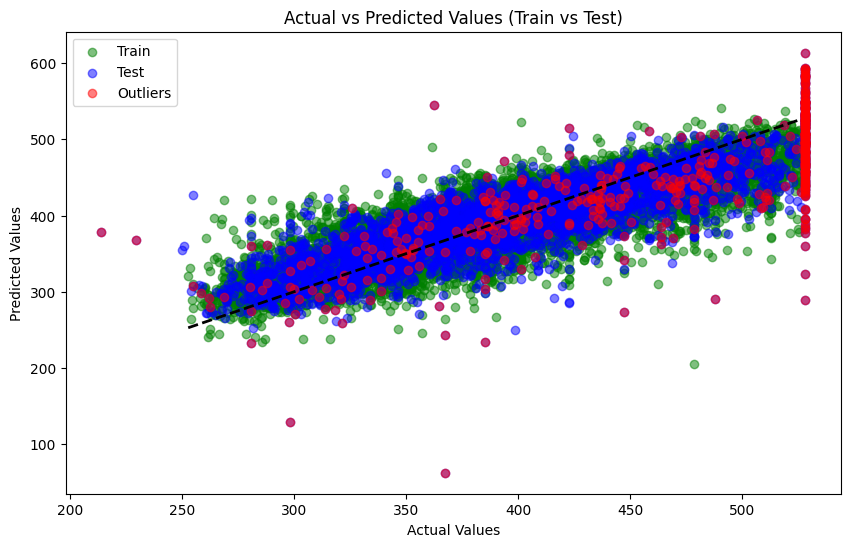

In [140]:

y_train_pred = best_model.predict(x_train_c)
y_test_pred = best_model.predict(x_test)
y_outliers_pred = best_model.predict(x_test_outliers)

plt.figure(figsize=(10,6))

plt.scatter(y_train_c, y_train_pred, label='Train', alpha=0.5, c='g')
plt.scatter(y_test, y_test_pred, label='Test', alpha=0.5, c='b')
plt.scatter(y_test_outliers, y_outliers_pred, label='Outliers', alpha=0.5, c='r')


plt.plot([y_train_c.min(), y_train_c.max()],
         [y_train_c.min(), y_train_c.max()],
         'k--', linewidth=2)

plt.title("Actual vs Predicted Values (Train vs Test)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()


**Interpretation:**

* For smaller actual values (< 350), the predicted values are slightly higher than the perfect-fit diagonal line.
* For larger actual values (> 450), the predicted values are slightly lower than the diagonal line.
* Compared to SGDRegressor plot, the points are more tightly clustered around the diagonal line, which means:
  * Reduced variance in errors
  * Better capture of non-linear relationships
  * Less severe underprediction at the high end

*While polynomial regression provides meaningful improvement over the linear SGDRegressor, the remaining prediction bias suggests that a more expressive model (e.g., XGBoost, RandomForestRegressor,...) may be required for further performance gains.

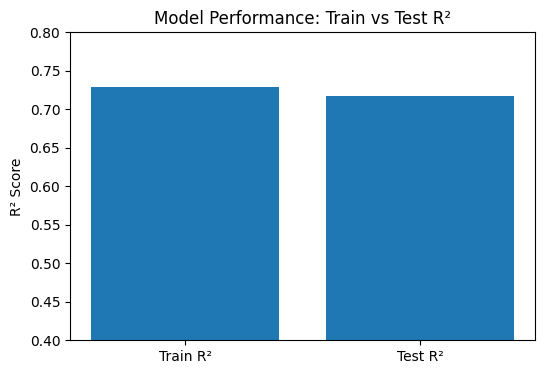

In [141]:
r2_train = best_model.score(x_train_c, y_train_c)
r2_test = best_model.score(x_test, y_test)

plt.figure(figsize=(6,4))
plt.bar(['Train R²', 'Test R²'], [r2_train, r2_test])
plt.title("Model Performance: Train vs Test R²")
plt.ylabel("R² Score")
plt.ylim(0.4,0.8)
plt.show()
